In [1]:
import pandas as pd
from pyvi import ViTokenizer
import re
import nltk
import seaborn as sns
from matplotlib import pyplot
import numpy as np

# 1. Import data

In [58]:
train_filename = "train_nor_811.xlsx"
valid_filename = "valid_nor_811.xlsx"
test_filename = "test_nor_811.xlsx"
train_data = pd.read_excel(train_filename, engine = "openpyxl")
valid_data = pd.read_excel(valid_filename, engine = "openpyxl")
test_data = pd.read_excel(test_filename, engine = "openpyxl")

In [59]:
from sklearn.preprocessing import LabelEncoder
def file_processing(data):
    data.drop(columns = {"Unnamed: 0"}, axis = 1, inplace = True)
    data["emotion_encode"] = data["Emotion"]
    encoder = LabelEncoder()
    data.emotion_encode = encoder.fit_transform(data.Emotion)
    return data

In [60]:
train_data = file_processing(train_data)
valid_data = file_processing(valid_data)
test_data = file_processing(test_data)

In [61]:
crawl_filename = "crawComments.xlsx"
crawl_data = pd.read_excel(crawl_filename, engine = "openpyxl")

crawl_data["emotion_encode"] = crawl_data["Emotion"]
encoder = LabelEncoder()
crawl_data.emotion_encode = encoder.fit_transform(crawl_data.Emotion)

In [45]:
crawl_data.head()

,Emotion,Sentences,emotion_encode
0,Enjoyment,Tẩy chay công ty Thuỵ Điển nhưng vẫn ủng hộ Xi...,2
1,Other,"""Gió đưa cây cải về trời\n1kg rau muống dinh d...",4
2,Disgust,Tao sợ báo Việt Nam quá rồi từ vụ anh Dưa Leo ...,1
3,Ẹnjoyment,Vừa phơi vài chiếc quần xịp của HM vừa nghe a ...,7
4,Enjoyment,"Quả cuối video,cách tẩy chay quá đỉnh!",2


# 2. Data visualization

# 3. Data preprocessing

In [54]:
def remove_duplicate(word):
    prev_char = ""
    clean_word = ""
    for character in word:
        if(character != prev_char):
            clean_word += character
            prev_char = character
    return clean_word

In [55]:
def deEmojify(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def normalize_sentences(sentences):
    punc_lst = {'.', ',', '...', '-', '“', '”', ':', '(', ')', '"', '!', '&', ';', '?', '*', ']', '>', '…', '’',"``","''", "=", "%", "^", "@", "<", ">"}
    confusing_words = {"per"}
    acronym_word = {
        "ko" : "không",
        "k" : "không",
        "z" : "vậy",
        "v" : "vậy",
        "dzậy" : "vậy",
        "dậy": "vậy",
        "t" : "tao",
        "m" : "mày",
        "sgk" : "sách_giáo_khoa",
        "zi" : "vậy",
        "dth" : "dễ_thương",
        "dume": "đụ mẹ"
    }
    
    clean_sentences = []
    
    # remove punctuation and lowercase
    for sent in sentences:
        
        # remove emojis
        sent = deEmojify(sent)
        
        sent = nltk.word_tokenize(sent)
        temp = []
        for word in sent:
            word = word.lower()
            word = remove_duplicate(word)
            if (word in punc_lst or word in confusing_words):
                continue
            elif(word in acronym_word):
                temp.append(acronym_word[word])
            elif(word.isdigit()):
                temp.append("<NUM>")
            else:
                temp.append(word)
        # remove whitespace
        sent = ' '.join(temp)
        
        clean_sentences.append(sent)
        
    return clean_sentences

In [56]:
def normalize_dataset(data):
    sentences = []
    for i in range(len(data)):
        sentences.append(ViTokenizer.tokenize(data.Sentence[i]))
    
    sentences = normalize_sentences(sentences)
    encode_tags = data.emotion_encode
    
    # remove empty sentences
    for idx, sent in enumerate(sentences):
        if sent.strip() == "":
            del sentences[idx]
            del encode_tags[idx]
    
    return sentences, encode_tags

In [62]:
train_clean_sentences, train_encode_tags = normalize_dataset(train_data)
valid_clean_sentences, valid_encode_tags = normalize_dataset(valid_data)
test_clean_sentences, test_encode_tags = normalize_dataset(test_data)
crawl_clean_sentences, crawl_encode_tags = normalize_dataset(crawl_data)

# 4. Model architecture

In [63]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras import layers, activations , models , preprocessing , utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
import tensorflow as tf
from sklearn.metrics import classification_report

### Tokenizer

In [64]:
MAX_LEN = 150

tokenizer = Tokenizer(lower = True, split = ' ')
tokenizer.fit_on_texts(train_clean_sentences + valid_clean_sentences)

X_train = tokenizer.texts_to_sequences(train_clean_sentences)
X_train = pad_sequences(X_train, MAX_LEN, padding='post', truncating='post')

X_valid = tokenizer.texts_to_sequences(valid_clean_sentences)
X_valid = pad_sequences(X_valid, MAX_LEN, padding='post', truncating='post')

X_test = tokenizer.texts_to_sequences(test_clean_sentences)
X_test = pad_sequences(X_test, MAX_LEN, padding='post', truncating='post')

X_crawl = tokenizer.texts_to_sequences(crawl_clean_sentences)
X_crawl = pad_sequences(X_crawl, MAX_LEN, padding='post', truncating='post')

In [65]:
vocab_size = len(tokenizer.word_index) + 1

### Word2Vec

In [108]:
from gensim.models import Word2Vec
import numpy as np
MAX_LEN = 150
w2v_model = Word2Vec(train_clean_sentences + valid_clean_sentences, min_count = 1, size = MAX_LEN)

In [109]:
def convert2vec(sentence):
    _sum = np.array([0]*MAX_LEN)
    for word in sentence:
        if not(word in w2v_model.wv.vocab):
            continue
        vec = w2v_model.wv[word]
        _sum = _sum + vec
    return _sum/len(sentence)

In [110]:
X_train = []
for sent in train_clean_sentences:
    if len(sent) == 0:
        X_train.append(np.array([0]*MAX_LEN))
    else:
        X_train.append(convert2vec(sent))
X_train = np.array(X_train)

X_valid = []
for sent in valid_clean_sentences:
    if len(sent) == 0:
        X_valid.append(np.array([0]*MAX_LEN))
    else:
        X_valid.append(convert2vec(sent))
X_valid = np.array(X_valid)

### TF IDF

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf = True, max_features = 3000)

fitted_vectorizer = tfidf_vectorizer.fit(train_clean_sentences)

X_train = fitted_vectorizer.transform(train_clean_sentences).toarray()

X_valid = fitted_vectorizer.transform(valid_clean_sentences).toarray()

X_test = fitted_vectorizer.transform(test_clean_sentences).toarray()

X_crawl = fitted_vectorizer.transform(crawl_clean_sentences).toarray()

## 4.1 CNN Model

In [12]:
embedding_dim = 128

inputs = layers.Input(shape=( MAX_LEN , ))
embedding = layers.Embedding(vocab_size, embedding_dim, input_length=MAX_LEN)(inputs)

cnn1 = layers.Conv1D(filters=100, kernel_size=1, activation='relu')(embedding)
cnn1 = layers.MaxPooling1D(pool_size=2)(cnn1)
cnn1 = Flatten()(cnn1)

cnn2 = layers.Conv1D(filters=100, kernel_size=2, activation='relu')(embedding)
cnn2 = layers.MaxPooling1D(pool_size=2)(cnn2)
cnn2 = Flatten()(cnn2)

outputs = layers.Concatenate()([cnn1,cnn2])

outputs = layers.Dense(28, activation='tanh')(outputs)
outputs = layers.Dense(14, activation='tanh')(outputs)
outputs = layers.Dense(7, activation='softmax')(outputs)
model=models.Model(inputs,outputs)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# model.summary()

In [13]:
y_train = tf.keras.utils.to_categorical(train_encode_tags)
y_valid = tf.keras.utils.to_categorical(valid_encode_tags)

In [14]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train,
                    epochs = 10,
                    callbacks = [es],
                    validation_data=(X_valid, y_valid),
                    batch_size = 32)

Epoch 1/10
174/174 [==============================] - 10s 57ms/step - loss: 0.3717 - accuracy: 0.3083 - val_loss: 0.3484 - val_accuracy: 0.3878
Epoch 2/10
174/174 [==============================] - 10s 55ms/step - loss: 0.3044 - accuracy: 0.5053 - val_loss: 0.3261 - val_accuracy: 0.4504
Epoch 3/10
174/174 [==============================] - 10s 57ms/step - loss: 0.2107 - accuracy: 0.6988 - val_loss: 0.3334 - val_accuracy: 0.4898
Epoch 00003: early stopping


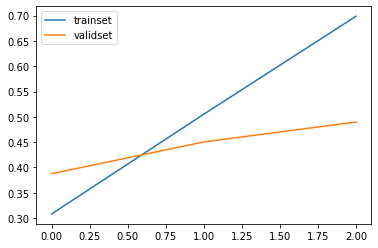

In [17]:
pyplot.plot(history.history['accuracy'], label='trainset') 
pyplot.plot(history.history['val_accuracy'], label='validset') 
pyplot.legend() 
pyplot.show()

In [15]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

In [16]:
print(classification_report(test_encode_tags, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.07      0.13        40
           1       0.44      0.64      0.52       132
           2       0.53      0.60      0.57       193
           3       0.68      0.41      0.51        46
           4       0.39      0.43      0.41       129
           5       0.52      0.44      0.48       116
           6       0.73      0.22      0.33        37

    accuracy                           0.49       693
   macro avg       0.54      0.40      0.42       693
weighted avg       0.51      0.49      0.47       693



In [68]:
y_pred_crawl = model.predict(X_crawl)
y_pred_crawl = np.argmax(y_pred_crawl, axis = 1)
print(classification_report(crawl_encode_tags, y_pred_crawl))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.24      0.37      0.29        35
           2       0.55      0.74      0.63       114
           3       0.50      0.24      0.32        21
           4       0.30      0.29      0.30        51
           5       0.12      0.43      0.19         7
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00         1

    accuracy                           0.41       295
   macro avg       0.21      0.26      0.22       295
weighted avg       0.33      0.41      0.36       295



c:\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.2 BiLSTM model

In [35]:
bi_model = Sequential()
bi_model.add(Embedding(vocab_size, embedding_dim, input_length=MAX_LEN))
bi_model.add(SpatialDropout1D(0.2))
bi_model.add(layers.Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
bi_model.add(Dense(7, activation='softmax'))
bi_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
bi_history = bi_model.fit(X_train, y_train,
                    epochs=10,
                    callbacks = [es],
                    validation_data=(X_valid, y_valid),
                    batch_size=32)

Epoch 1/10
174/174 [==============================] - 342s 2s/step - loss: 1.7011 - accuracy: 0.3290 - val_loss: 1.4933 - val_accuracy: 0.4271
Epoch 2/10
174/174 [==============================] - 303s 2s/step - loss: 1.3068 - accuracy: 0.5156 - val_loss: 1.3516 - val_accuracy: 0.4796
Epoch 3/10
174/174 [==============================] - 304s 2s/step - loss: 0.9929 - accuracy: 0.6394 - val_loss: 1.3361 - val_accuracy: 0.5029
Epoch 4/10
174/174 [==============================] - 301s 2s/step - loss: 0.7857 - accuracy: 0.7193 - val_loss: 1.3595 - val_accuracy: 0.5160
Epoch 00004: early stopping


In [48]:
bi_model.save("bi_model.h5")

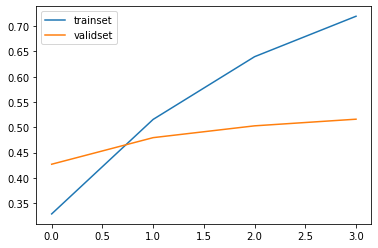

In [39]:
pyplot.plot(bi_history.history['accuracy'], label='trainset') 
pyplot.plot(bi_history.history['val_accuracy'], label='validset') 
pyplot.legend() 
pyplot.show()

In [37]:
y_pred = bi_model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

In [38]:
print(classification_report(test_encode_tags, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.47      0.44        40
           1       0.52      0.60      0.55       132
           2       0.63      0.60      0.62       193
           3       0.83      0.41      0.55        46
           4       0.38      0.50      0.44       129
           5       0.62      0.55      0.58       116
           6       0.80      0.32      0.46        37

    accuracy                           0.54       693
   macro avg       0.60      0.50      0.52       693
weighted avg       0.57      0.54      0.54       693



In [70]:
y_pred_crawl = bi_model.predict(X_crawl)
y_pred_crawl = np.argmax(y_pred_crawl, axis = 1)
print(classification_report(crawl_encode_tags, y_pred_crawl))

              precision    recall  f1-score   support

           0       0.50      0.06      0.11        49
           1       0.25      0.37      0.30        35
           2       0.54      0.64      0.58       114
           3       0.62      0.24      0.34        21
           4       0.25      0.29      0.27        51
           5       0.17      0.71      0.28         7
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00         1

    accuracy                           0.39       295
   macro avg       0.29      0.29      0.24       295
weighted avg       0.41      0.39      0.36       295



c:\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.3 Dense + TF IDF vectorize

In [76]:
model_3 = Sequential()
model_3.add(layers.Dense(512, activation = "relu"))
model_3.add(layers.Dense(128, activation = "sigmoid"))
model_3.add(layers.Dense(7, activation = "softmax"))
model_3.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy'])

In [77]:
y_train = tf.keras.utils.to_categorical(train_encode_tags)
y_valid = tf.keras.utils.to_categorical(valid_encode_tags)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history_3 = model_3.fit(X_train, y_train,
                    epochs=10,
                    callbacks = [es],
                    validation_data=(X_valid, y_valid),
                    batch_size=64)

Epoch 1/10
87/87 [==============================] - 2s 18ms/step - loss: 1.8030 - accuracy: 0.2699 - val_loss: 1.5749 - val_accuracy: 0.4184
Epoch 2/10
87/87 [==============================] - 1s 15ms/step - loss: 1.3255 - accuracy: 0.5288 - val_loss: 1.3104 - val_accuracy: 0.4927
Epoch 3/10
87/87 [==============================] - 1s 15ms/step - loss: 0.8969 - accuracy: 0.7081 - val_loss: 1.2754 - val_accuracy: 0.5292
Epoch 4/10
87/87 [==============================] - 1s 15ms/step - loss: 0.6277 - accuracy: 0.8053 - val_loss: 1.3508 - val_accuracy: 0.5364
Epoch 00004: early stopping


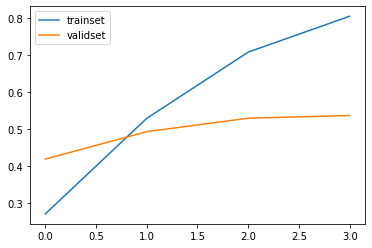

In [78]:
pyplot.plot(history_3.history['accuracy'], label='trainset') 
pyplot.plot(history_3.history['val_accuracy'], label='validset') 
pyplot.legend() 
pyplot.show()

In [49]:
y_pred = model_3.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

In [50]:
print(classification_report(test_encode_tags, y_pred))

              precision    recall  f1-score   support

           0       0.38      0.15      0.21        40
           1       0.50      0.68      0.58       132
           2       0.58      0.59      0.58       193
           3       0.79      0.59      0.68        46
           4       0.43      0.48      0.46       129
           5       0.54      0.56      0.55       116
           6       1.00      0.08      0.15        37

    accuracy                           0.53       693
   macro avg       0.60      0.45      0.46       693
weighted avg       0.55      0.53      0.51       693



In [79]:
y_pred_crawl = model_3.predict(X_crawl)
y_pred_crawl = np.argmax(y_pred_crawl, axis = 1)
print(classification_report(crawl_encode_tags, y_pred_crawl))

              precision    recall  f1-score   support

           0       0.40      0.04      0.07        49
           1       0.14      0.23      0.17        35
           2       0.55      0.62      0.58       114
           3       0.50      0.19      0.28        21
           4       0.27      0.33      0.30        51
           5       0.19      0.71      0.30         7
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00         1

    accuracy                           0.36       295
   macro avg       0.25      0.27      0.21       295
weighted avg       0.38      0.36      0.34       295



c:\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 4.4 Linear SVC + TF IDF vectorize

In [82]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [83]:
linear_svc = LinearSVC()
clf = linear_svc.fit(X_train, train_encode_tags)

svc_model = CalibratedClassifierCV(base_estimator=linear_svc, cv="prefit")

svc_model.fit(X_train, train_encode_tags)
y_pred = svc_model.predict(X_test)

In [37]:
print(classification_report(test_encode_tags, y_pred))

              precision    recall  f1-score   support

           0       0.27      0.30      0.29        40
           1       0.51      0.54      0.53       132
           2       0.56      0.60      0.58       193
           3       0.64      0.63      0.64        46
           4       0.48      0.45      0.46       129
           5       0.55      0.54      0.55       116
           6       0.58      0.41      0.48        37

    accuracy                           0.52       693
   macro avg       0.51      0.49      0.50       693
weighted avg       0.53      0.52      0.52       693



In [84]:
y_pred_crawl = svc_model.predict(X_crawl)
print(classification_report(crawl_encode_tags, y_pred_crawl))

              precision    recall  f1-score   support

           0       0.33      0.02      0.04        49
           1       0.18      0.23      0.20        35
           2       0.60      0.56      0.58       114
           3       0.45      0.24      0.31        21
           4       0.31      0.51      0.39        51
           5       0.16      0.71      0.26         7
           6       0.07      0.06      0.06        17
           7       0.00      0.00      0.00         1

    accuracy                           0.37       295
   macro avg       0.26      0.29      0.23       295
weighted avg       0.40      0.37      0.35       295



c:\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
